## About Data

A training set for academic machine learning can be created using the dataset, which comprises of 10015 dermatoscopic images. All significant diagnostic categories for pigmented lesions are represented in the cases in a representative manner:

 - Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
 - basal cell carcinoma (bcc),
 - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
 - dermatofibroma (df),
 - melanoma (mel),
 - melanocytic nevi (nv) and
 - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).
 
Histopathology (histo) is used to confirm more than 50% of lesions; in the remaining cases, follow-up exams, expert consensus, or in-vivo confocal microscopy confirmation are used as the gold standard (confocal).

Dataset Collected from:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import PIL

In [3]:
data = r"Skin Cancer"
metadata = pd.read_csv("HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Making Categories for each Skin Cancer

In [4]:
import os
import shutil
import pandas as pd

# Load metadata (assuming a CSV file)
metadata = pd.read_csv("HAM10000_metadata.csv")  # Adjust the filename accordingly

# Folder containing images
image_folder = r"Skin Cancer"

# Ensure destination directory exists
destination_root = "Categories"
os.makedirs(destination_root, exist_ok=True)

# Process images
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')):  
        image_path = os.path.join(image_folder, filename)
        image_name = os.path.splitext(filename)[0]  # Extract filename without extension

        print(f"Processing: {image_name}")

        # Find metadata entry
        matched_rows = metadata[metadata["image_id"] == image_name]

        if not matched_rows.empty:
            dx_category = matched_rows.iloc[0]["dx"]  # Extract category
            destination_folder = os.path.join(destination_root, dx_category)
            os.makedirs(destination_folder, exist_ok=True)

            # Move the image with its original extension
            shutil.move(image_path, os.path.join(destination_folder, filename))


In [10]:
from keras.preprocessing.image import ImageDataGenerator


train = "Categories"
val = "Test Data"
img_width , img_height = 128 , 128
input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Add validation split
)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # ← Important
)

val_generator = train_datagen.flow_from_directory(
    train,  # same directory
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # ← Important
)


Found 7957 images belonging to 7 classes.
Found 1986 images belonging to 7 classes.


In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32 , (3,3) , activation='relu',input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64 , (3,3) , activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128 , (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512 , activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7 , activation='softmax')
])

model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)     

In [12]:
tf.debugging.set_log_device_placement(True)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20
)


Epoch 1/20
248/248 [==============================] - 78s 312ms/step - loss: 1.0601 - accuracy: 0.6675 - val_loss: 0.9366 - val_accuracy: 0.6734
Epoch 2/20
248/248 [==============================] - 73s 294ms/step - loss: 0.9639 - accuracy: 0.6714 - val_loss: 0.8733 - val_accuracy: 0.6729
Epoch 3/20
248/248 [==============================] - 74s 299ms/step - loss: 0.9411 - accuracy: 0.6697 - val_loss: 0.9182 - val_accuracy: 0.6749
Epoch 4/20
248/248 [==============================] - 72s 291ms/step - loss: 0.9248 - accuracy: 0.6712 - val_loss: 0.8819 - val_accuracy: 0.6739
Epoch 5/20
248/248 [==============================] - 73s 293ms/step - loss: 0.9024 - accuracy: 0.6723 - val_loss: 0.8941 - val_accuracy: 0.6815
Epoch 6/20
248/248 [==============================] - 72s 291ms/step - loss: 0.8967 - accuracy: 0.6779 - val_loss: 0.8692 - val_accuracy: 0.6744
Epoch 7/20
248/248 [==============================] - 72s 290ms/step - loss: 0.8717 - accuracy: 0.6810 - val_loss: 0.8187 - val_ac

In [13]:
model.save("model2.h5")

In [14]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


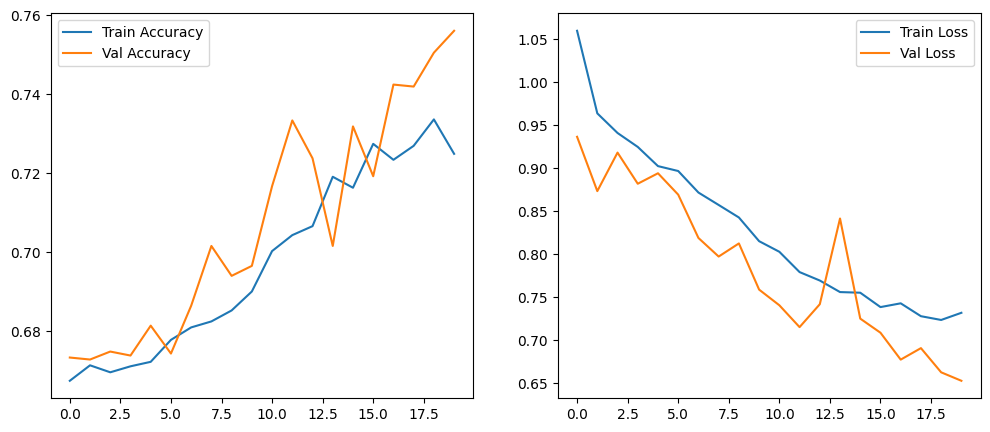

In [15]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()

plt.show()


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

classes = ["Akiec" , "BCC" , "BKL" , "DF" , "MEL" , "NV" , "Vasc"]
# Step 2: Load and preprocess the image
img_path = r"D:\Self_Study\Tutorials ♥♥\Machine Learning\Skin Cancer\Test Data\mel\ISIC_0024310.jpg"
img = image.load_img(img_path, target_size=(img_height, img_width))  # use same size as training
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if model was trained this way
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Step 3: Predict
predictions = model.predict(img_array)

# Step 4: Interpret
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class index: {classes[predicted_class[0]]}")

1/1 [==============================] - 0s 28ms/step
Predicted class index: MEL
